## Definitions

### Libraries, Devices

In [17]:
import warnings

warnings.filterwarnings("ignore")

import itertools
import os
import random
import sys
import torch.nn.functional as F
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp
import torch
import xarray as xr
from torch.utils.data import Dataset
import math
from tqdm import tqdm


from cosine_annealing_warmup import CosineAnnealingWarmupRestarts

# from torch.optim.lr_scheduler import ReduceLROnPlateau
from holodecml.transforms import LoadTransformations
from echo.src.base_objective import BaseObjective

# from holodecml.seed import seed_everything
from holodecml.data import XarrayReader
from holodecml.models import load_model
from holodecml.losses import load_loss

from collections import defaultdict
from argparse import ArgumentParser
from pathlib import Path
from torch.utils.data import Dataset


import xarray as xr
import torch.nn.functional as F
import pandas as pd
import numpy as np
import subprocess
import torch.fft
import logging
import shutil
import random
import psutil
import optuna
import torch
import time
import tqdm
import gc
import os
import sys
import itertools
import yaml
import warnings

In [18]:
torch.cuda.empty_cache()

In [19]:
is_cuda = torch.cuda.is_available()
print(is_cuda)
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")
print(device)
if is_cuda:
    torch.backends.cudnn.benchmark = True
    #torch.backends.cudnn.deterministic = True

True
cuda:0


### Filepaths

In [20]:
train_dataset_path = "/glade/p/cisl/aiml/ai4ess_hackathon/holodec/synthetic_holograms_500particle_gamma_4872x3248_training.nc"
test_dataset_path = "/glade/p/cisl/aiml/ai4ess_hackathon/holodec/synthetic_holograms_500particle_gamma_4872x3248_validation.nc"

conf_file_path = "../results/batch7/model.yml"

### Processing Functions

### Loading Functions

In [21]:
class WavePropagator(object):

    def __init__(self,
                 data_path,
                 n_bins=1000,
                 step_size=128,
                 tile_size = 128,
                 marker_size=10,
                 transform_mode=None,
                 device="cpu"):

        self.h_ds = xr.open_dataset(data_path)


        if 'zMin' in self.h_ds.attrs:
            self.zMin = self.h_ds.attrs['zMin']  # minimum z in sample volume
            self.zMax = self.h_ds.attrs['zMax']
        else:  # some of the raw data does not have this parameter
            # should warn the user here through the logger
            self.zMin = 0.014
            self.zMax = 0.158 #15.8 - 1.4 / (1000)

        self.n_bins = n_bins
        self.z_bins = np.linspace(
            self.zMin, self.zMax, n_bins+1)*1e6  # histogram bin edges
        self.z_centers = self.z_bins[:-1] + 0.5 * \
            np.diff(self.z_bins)  # histogram bin center
        
        self.tile_size = tile_size
        self.step_size = step_size
        
        # UNET gaussian marker width (standard deviation) in um
        self.marker_size = marker_size
        self.device = device


        self.dx = self.h_ds.attrs['dx']      # horizontal resolution
        self.dy = self.h_ds.attrs['dy']      # vertical resolution
        self.Nx = int(self.h_ds.attrs['Nx'])  # number of horizontal pixels
        self.Ny = int(self.h_ds.attrs['Ny'])  # number of vertical pixels
        self.lam = self.h_ds.attrs['lambda']  # wavelength
        self.image_norm = 255.0
        self.transform_mode = transform_mode
        self.x_arr = np.arange(-self.Nx//2, self.Nx//2)*self.dx
        self.y_arr = np.arange(-self.Ny//2, self.Ny//2)*self.dy

        self.tile_x_bins = np.arange(-self.Nx//2,
                                     self.Nx//2, self.step_size)*self.dx*1e6
        self.tile_y_bins = np.arange(-self.Ny//2,
                                     self.Ny//2, self.step_size)*self.dy*1e6

        self.fx = torch.fft.fftfreq(
            self.Nx, self.dx, device=self.device).unsqueeze(0).unsqueeze(2)
        self.fy = torch.fft.fftfreq(
            self.Ny, self.dy, device=self.device).unsqueeze(0).unsqueeze(1)

        
        self.create_mapping()
    def torch_holo_set(self,
                       Ein: torch.tensor,
                       z_tnsr: torch.tensor):
        """
        Propagates an electric field a distance z
        Ein complex torch.tensor
        - input electric field

        fx:real torch.tensor
        - x frequency axis (3D, setup to broadcast)

        fy: real torch.tensor
        - y frequency axis (3D, setup to broadcast)

        z_tnsr: torch.tensor
        - tensor of distances to propagate the wave Ein
            expected to have dims (Nz,1,1) where Nz is the number of z
            dimensions

        lam: float
        - wavelength

        returns: complex torch.tensor with dims (Nz,fy,fx)

        Note the torch.fft library uses dtype=torch.complex64
        This may be an issue for GPU implementation

        """

        if self.transform_mode == "standard":
            Ein = Ein.float()
            Ein -= torch.mean(Ein)
            Ein /= torch.std(Ein)

        elif self.transform_mode == "min-max":
            Ein = Ein.float()
            Ein -= torch.min(Ein)
            Ein /= torch.max(Ein)

        Etfft = torch.fft.fft2(Ein)
        Eofft = Etfft*torch.exp(1j*2*np.pi*z_tnsr/self.lam *
                                torch.sqrt(1-self.lam**2*(self.fx**2+self.fy**2)))

        # It might be helpful if we could omit this step.  It would save an inverse fft.
        Eout = torch.fft.ifft2(Eofft)
        return Eout
    
    
    def create_mapping(self):
        """
        Create map from tile coordinates (x,y) to indices to slice in image to extract that tile. 
        """
        self.idx2slice = {}
        for row_idx in range(self.Nx//self.step_size):

            if row_idx*self.step_size+self.tile_size > self.Nx:
                image_pixel_x = self.Nx-self.tile_size
                row_slice = slice(-self.tile_size, None)
                row_break = True
            else:
                image_pixel_x = row_idx*self.step_size
                row_slice = slice(row_idx*self.step_size,
                                  row_idx*self.step_size+self.tile_size)
                row_break = False

            for col_idx in range(self.Ny//self.step_size):

                if col_idx*self.step_size+self.tile_size > self.Ny:
                    image_pixel_y = self.Ny-self.tile_size
                    col_slice = slice(-self.tile_size, None)
                    col_break = True
                else:
                    image_pixel_y = col_idx*self.step_size
                    col_slice = slice(col_idx*self.step_size,
                                      col_idx*self.step_size+self.tile_size)
                    col_break = False

                self.idx2slice[row_idx, col_idx] = (row_slice, col_slice)

                if col_break:
                    break

            if row_break:
                break
                
                
                
    def collate_image(self, idx_dict, image = None, mask = None):
        x, y = zip(*[(image[:, row_slice, col_slice], mask[row_slice, col_slice]) for ((row_idx, col_idx, row_slice, col_slice)) in idx_dict])


In [22]:
def create_mask(prop, h_idx, z_idx, z_ref):

    hid = h_idx + 1
    hid_mask = prop.h_ds["hid"] == hid

    # Filter particles based on h_idx
    x_part = prop.h_ds["x"].values[hid_mask]
    y_part = prop.h_ds["y"].values[hid_mask]
    z_part = prop.h_ds["z"].values[hid_mask]
    d_part = prop.h_ds["d"].values[hid_mask]

    z_indices = np.digitize(z_part, prop.z_bins) - 1
    # Initialize the UNET mask
    unet_mask = np.zeros((prop.x_arr.shape[0], prop.y_arr.shape[0]))
    z_mask = np.zeros((prop.x_arr.shape[0], prop.y_arr.shape[0]))
    num_particles = 0 
    
    if z_idx in z_indices:
        cond = np.where(z_idx == z_indices)
        x_part = x_part[cond]
        y_part = y_part[cond]
        z_part = z_part[cond]
        d_part = d_part[cond]
        
        #print(x_part, y_part, z_part, d_part)
        
        # Build the UNET mask using vectorized operations
        for part_idx in range(len(cond[0])):
            y_diff = (prop.y_arr[None, :] * 1e6 - y_part[part_idx])
            x_diff = (prop.x_arr[:, None] * 1e6 - x_part[part_idx])
            d_squared = (d_part[part_idx] / 2)**2
            unet_mask += ((y_diff**2 + x_diff**2) < d_squared).astype(float)
            z_diff = (z_part - z_ref)
            for particle in z_diff:
                z_mask += ((y_diff**2 + x_diff**2) < d_squared).astype(float) * particle
                num_particles += 1

    return torch.from_numpy(unet_mask).unsqueeze(0), num_particles, torch.from_numpy(z_mask).unsqueeze(0)


In [59]:
class LoadHolograms(Dataset):
    
    def __init__(self, file_path, n_bins = 1000, shuffle = False, device = "cpu", transform = False, lookahead =0, step_size = 32, tile_size = 32):
        
        # num of waveprop windows
        self.n_bins = n_bins
        # device used
        self.device = device
        # shuffle frames
        self.shuffle = shuffle
        # num of frames to look ahead
        self.lookahead = lookahead
        # wavepropagator object on device
        self.propagator = WavePropagator(file_path, n_bins = n_bins, device = device, step_size = step_size, tile_size = tile_size)
        self.transform = transform
        self.indices =  [(x,y) for x in self.propagator.h_ds.hologram_number for y in range(self.n_bins - self.lookahead)]
        
        self.tile_size = tile_size
        self.idx2slice = self.propagator.idx2slice

    def __len__(self):
        return len(self.indices) * len(self.idx2slice)

    # idx = tile index
    def __getitem__(self, idx):
        
        if self.shuffle:
            idx = random.choice(range(self.__len__()))
            
        #hologram_idx = idx // self.n_bins 
        #plane_idx = idx // len(self.propagator.h_ds.hologram_number)
        hologram_idx, plane_idx = self.indices[(idx) // len(self.idx2slice)]
        z_props = self.propagator.z_centers[plane_idx: plane_idx + self.lookahead + 1]
        #z_props -= (z_props[1] - z_props[0]) / 2
        plane_indices = np.arange(plane_idx, plane_idx + self.lookahead + 1)
        # select hologram
        image = self.propagator.h_ds["image"].isel(hologram_number=hologram_idx).values
        
        im = {
            "image": np.expand_dims(image, 0),
            "horizontal_flip": False,
            "vertical_flip": False
        }

        # add transformations here
        if self.transform:
            for image_transform in self.transform:
                im = image_transform(im)
        image = im["image"]
        
        # Update the mask if we flipped the original image
        
        
        # prop
        
        # make tensors of size lookahead + 1, and then add tensors
        prop_synths = []
        prop_phases = []
        masks = []
        z_masks = []
        particles_in_frames = []
        
        #num_frames = len(plane_indices)
        #idx_ran = random.choice(range(num_frames))
        #z_prop = z_props[idx_ran]
        #z_ind = plane_indices[idx_ran]
        
        for k, (z_prop, z_ind) in enumerate(zip(z_props, plane_indices)):
            image_prop = self.propagator.torch_holo_set(
                image.to(self.device),
                torch.FloatTensor([z_prop*1e-6]).to(self.device)
            )
            # ABS (x-input)
            prop_synth = torch.abs(image_prop)
            prop_synths.append(prop_synth)
            # Phase (x-input)
            prop_phase = torch.angle(image_prop)
            prop_phases.append(prop_phase)  
            # Mask (y-label)
            if k == 0:
                mask, num_particles, z_mask = create_mask(self.propagator, hologram_idx, z_ind, z_prop)
                if im["horizontal_flip"]:
                    mask = torch.flip(mask, dims=(1,))
                    z_mask = torch.flip(z_mask, dims= (1,))
                if im["vertical_flip"]:
                    mask = torch.flip(mask, dims=(2,))
                    z_mask = torch.flip(z_mask, dims= (2,))
                masks.append(mask)
                z_masks.append(z_mask)

        
        
        # cat target frames with lookahead context frames, convert to ndarrays
        synth_window = torch.cat(prop_synths, dim = 0)
        phases_window = torch.cat(prop_phases, dim = 0)
        masks_window = torch.cat(masks, dim = 0)
        z_masks_window = torch.cat(z_masks, dim = 0)
        z_masks_window /= (z_props[-1] - z_props[0])
        
        # cat images and masks in color dim (0 since batch not added yet)
        image_stack = torch.cat([synth_window, phases_window], dim = 0)
        """
        masks_stack = torch.cat([masks_window, z_masks_window], dim = 0)
        """
        masks_stack = torch.cat([masks_window], dim = 0)
        
        #get tiles, slicing along coords in idx2slice array that maps coord position to slice range
        slice_coords = self.idx2slice[list(self.idx2slice)[idx % len(self.idx2slice)]]
        image_stack = image_stack[:, slice_coords[0], slice_coords[1]]
        masks_stack = masks_stack[:, slice_coords[0], slice_coords[1]]
        
        return (image_stack, masks_stack)
    
    def get_full_plane(self, idx, device = "cpu"):
        if self.shuffle:
            idx = random.choice(range(self.__len__()))
            
        #hologram_idx = idx // self.n_bins 
        #plane_idx = idx // len(self.propagator.h_ds.hologram_number)
        hologram_idx, plane_idx = self.indices[(idx) // len(self.idx2slice)]
        z_props = self.propagator.z_centers[plane_idx: plane_idx + self.lookahead + 1]
        #z_props -= (z_props[1] - z_props[0]) / 2
        plane_indices = np.arange(plane_idx, plane_idx + self.lookahead + 1)
        # select hologram
        image = self.propagator.h_ds["image"].isel(hologram_number=hologram_idx).values
        
        im = {
            "image": np.expand_dims(image, 0),
            "horizontal_flip": False,
            "vertical_flip": False
        }

        # add transformations here
        if self.transform:
            for image_transform in self.transform:
                im = image_transform(im)
        image = im["image"]
        
        # Update the mask if we flipped the original image
        
        
        # prop
        
        # make tensors of size lookahead + 1, and then add tensors
        prop_synths = []
        prop_phases = []
        masks = []
        z_masks = []
        particles_in_frames = []
        
        #num_frames = len(plane_indices)
        #idx_ran = random.choice(range(num_frames))
        #z_prop = z_props[idx_ran]
        #z_ind = plane_indices[idx_ran]
        
        for k, (z_prop, z_ind) in enumerate(zip(z_props, plane_indices)):
            image_prop = self.propagator.torch_holo_set(
                image.to(device),
                torch.FloatTensor([z_prop*1e-6]).to(device)
            )
            # ABS (x-input)
            prop_synth = torch.abs(image_prop)
            prop_synths.append(prop_synth)
            # Phase (x-input)
            prop_phase = torch.angle(image_prop)
            prop_phases.append(prop_phase)  
            # Mask (y-label)
            if k == 0:
                mask, num_particles, z_mask = create_mask(self.propagator, hologram_idx, z_ind, z_prop)
                if im["horizontal_flip"]:
                    mask = torch.flip(mask, dims=(1,))
                    z_mask = torch.flip(z_mask, dims= (1,))
                if im["vertical_flip"]:
                    mask = torch.flip(mask, dims=(2,))
                    z_mask = torch.flip(z_mask, dims= (2,))
                masks.append(mask)
                z_masks.append(z_mask)

        
        
        # cat target frames with lookahead context frames, convert to ndarrays
        synth_window = torch.cat(prop_synths, dim = 0)
        phases_window = torch.cat(prop_phases, dim = 0)
        masks_window = torch.cat(masks, dim = 0)
        z_masks_window = torch.cat(z_masks, dim = 0)
        z_masks_window /= (z_props[-1] - z_props[0])
        
        # cat images and masks in color dim (0 since batch not added yet)
        image_stack = torch.cat([synth_window, phases_window], dim = 0)
        """
        masks_stack = torch.cat([masks_window, z_masks_window], dim = 0)
        """
        masks_stack = torch.cat([masks_window], dim = 0)
        
        return (image_stack, masks_stack)
        
        
        # given a full image, slice coordinates defined in slice.idx2slice, return dict of tiles {(x,y): tensor}
    def sequential_tile(self, full_plane):
        tiles_dict = defaultdict()
        for slice_coords in self.idx2slice:
            tiles_dict[slice_coords] = full_plane[:,self.idx2slice[slice_coords][0], self.idx2slice[slice_coords][1]]
        return tiles_dict
    
        # given dict of tiles {(x,y): tensor tile} (as returned from sequential_tile()), reconstruct full image
        # stride overlap is sum of both tiles
    def tile_reconstruct(self, tile_dict):
        largex, largey = self.idx2slice[list(self.idx2slice.keys())[-1]][0].stop, self.idx2slice[list(self.idx2slice.keys())[-1]][1].stop
        template = torch.zeros(1,1,largex, largey)
        counter = torch.zeros(largex, largey)
        #template = torch.zeros(1,tile_dict[list(tile_dict.keys())[0]].shape[1],largex, largey)
        for coords in tile_dict:
            tile = tile_dict[coords]
            slice_coords = self.idx2slice[coords]
            template[:, :, slice_coords[0], slice_coords[1]] += tile
            counter[slice_coords[0], slice_coords[1]] += 1
        return template, counter
            
        # given image index, model, loss function, device, get full images at idx, split in to tiles, and get tile-wise prediction from model
        # attach back together, and then evaluate loss between full prediction image and fullm ask image
    def full_inference(self, idx, model, loss = "dice", device = "cpu"):
        full_image, full_mask = self.get_full_plane(idx, device = device)
        image_tiles = self.sequential_tile(full_image)
        mask_tiles = self.sequential_tile(full_mask)
        with torch.no_grad():
            for coords in image_tiles:
                image_tiles[coords] = model(image_tiles[coords].unsqueeze(0))[:,0:1,:,:]
        full_inference_frame = self.tile_reconstruct(image_tiles)[0].squeeze(0)[0:1,:,:].float()
        full_inference_mask, full_mask_counter = self.tile_reconstruct(mask_tiles)
        test_criterion = load_loss(loss, split = "validation")
        val_loss = test_criterion(full_inference_frame, full_inference_mask)
        return(val_loss, full_inference_frame, full_mask_counter)
            

## Visualizations

In [60]:
torch.cuda.empty_cache()

# load in from config file
with open(conf_file_path) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

        
# edit color channels to be compatible with lookahead
conf["model"]["in_channels"] = 2 * (conf["data"]["lookahead"] + 1)

# load transformations from config
if "Normalize" in conf["transforms"]["training"]:
    conf["transforms"]["validation"]["Normalize"]["mode"] = conf["transforms"][
        "training"
    ]["Normalize"]["mode"]
    conf["transforms"]["inference"]["Normalize"]["mode"] = conf["transforms"][
        "training"
    ]["Normalize"]["mode"]

train_transforms = LoadTransformations(conf["transforms"]["training"])
valid_transforms = LoadTransformations(conf["transforms"]["validation"])

# load lookahead depth from config
lookahead = int(conf["data"]["lookahead"])

# Set up CUDA/CPU devices
is_cuda = torch.cuda.is_available()
data_device = (
    torch.device("cpu") if "device" not in conf["data"] else conf["data"]["device"]
)

if torch.cuda.device_count() >= 2 and "cuda" in data_device:
    data_device = "cuda:0"
    device = "cuda:1"
    device_ids = list(range(1, torch.cuda.device_count()))
else:
    data_device = torch.device("cpu")
    device = (
        torch.device(torch.cuda.current_device())
        if is_cuda
        else torch.device("cpu")
    )
    device_ids = list(range(torch.cuda.device_count()))
logging.info(f"There are {torch.cuda.device_count()} GPUs available")
logging.info(
    f"Using device {data_device} to perform wave propagation, and {device_ids} for training the model"
)


# load tiling size
step_size = int(conf["data"]["step_size"])
z_weight = int(conf["trainer"]["z_weight"])

# hard code shuffle, n_bins
shuffle =False
n_bins = 1000


In [61]:
# get data

train_dataset = LoadHolograms("/glade/p/cisl/aiml/ai4ess_hackathon/holodec/synthetic_holograms_500particle_gamma_4872x3248_training.nc", shuffle = False, device = data_device, n_bins = n_bins, transform = train_transforms, lookahead = 1, tile_size = 1024, step_size = 1024)

test_dataset = LoadHolograms("/glade/p/cisl/aiml/ai4ess_hackathon/holodec/synthetic_holograms_500particle_gamma_4872x3248_validation.nc", shuffle = False, device = data_device, n_bins = n_bins, transform = valid_transforms, lookahead = 1, tile_size = 1024, step_size = 1024)


157432 123
123

4


<Figure size 33.3333x618.034 with 0 Axes>

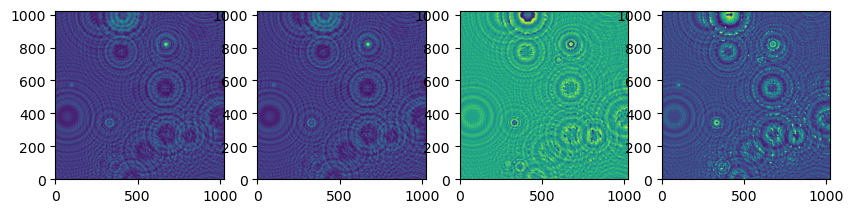

In [62]:
# check loading
randint = 1040529
rand_img_raw, rand_masks_raw = train_dataset.__getitem__(randint)

while (int(torch.count_nonzero(rand_masks_raw[0])) < 30):
    randint = random.randint(0,train_dataset.__len__())
    rand_img_raw, rand_masks_raw = train_dataset.__getitem__(randint)
print(randint, int(torch.count_nonzero(rand_masks_raw[0])))
print(len(torch.nonzero(rand_masks_raw[0], as_tuple = False)))
print()

rand_img_raw, rand_masks_raw = train_dataset.__getitem__(randint)
image = rand_img_raw
print(len(image))

fontsize = 10
single_column_width = 10
plt.figure(figsize = (single_column_width/30, single_column_width / 1.61803398875))
fig, ax = plt.subplots(1, 4, figsize=(single_column_width, single_column_width * 1.61803398875), 
                         gridspec_kw={'hspace': 0.0, 'wspace': 0.2})
ax = ax.flatten()
ax[0].imshow(image[0], origin ='lower')
ax[1].imshow(image[1], origin = 'lower')
ax[2].imshow(image[2], origin = 'lower')
ax[3].imshow(image[3], origin = 'lower')

In [63]:
model = load_model(conf["model"])
model_dict = torch.load("../results/batch7/best.pt")["model_state_dict"]
model.load_state_dict(model_dict)

inputs = train_dataset.__getitem__(randint)

pred_masks = model(inputs[0].unsqueeze(dim = 0))
pred_masks = torch.gt(pred_masks, 0.5)[0].detach().numpy()
#pred_masks = pred_masks[0].detach().numpy()
print(pred_masks.shape)

(2, 1024, 1024)


In [64]:
inp, masks = train_dataset.get_full_plane(randint)
print(inp.shape, masks.shape)

torch.Size([4, 4872, 3248]) torch.Size([1, 4872, 3248])


<Figure size 33.3333x618.034 with 0 Axes>

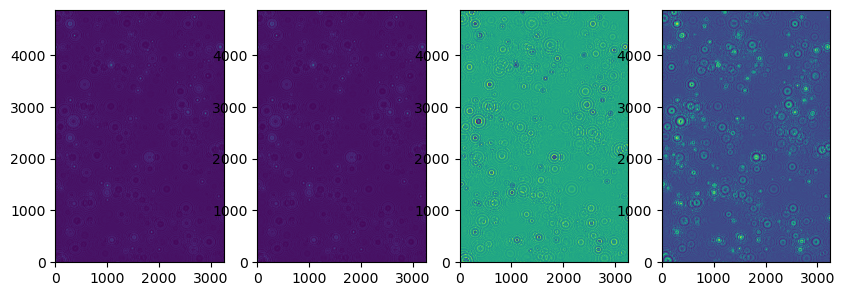

In [65]:
image = inp
fontsize = 10
single_column_width = 10
plt.figure(figsize = (single_column_width/30, single_column_width / 1.61803398875))
fig, ax = plt.subplots(1, 4, figsize=(single_column_width, single_column_width * 1.61803398875), 
                         gridspec_kw={'hspace': 0.0, 'wspace': 0.2})
ax = ax.flatten()
ax[0].imshow(image[0], origin ='lower')
ax[1].imshow(image[1], origin = 'lower')
ax[2].imshow(image[2], origin = 'lower')
ax[3].imshow(image[3], origin = 'lower')

<Figure size 33.3333x618.034 with 0 Axes>

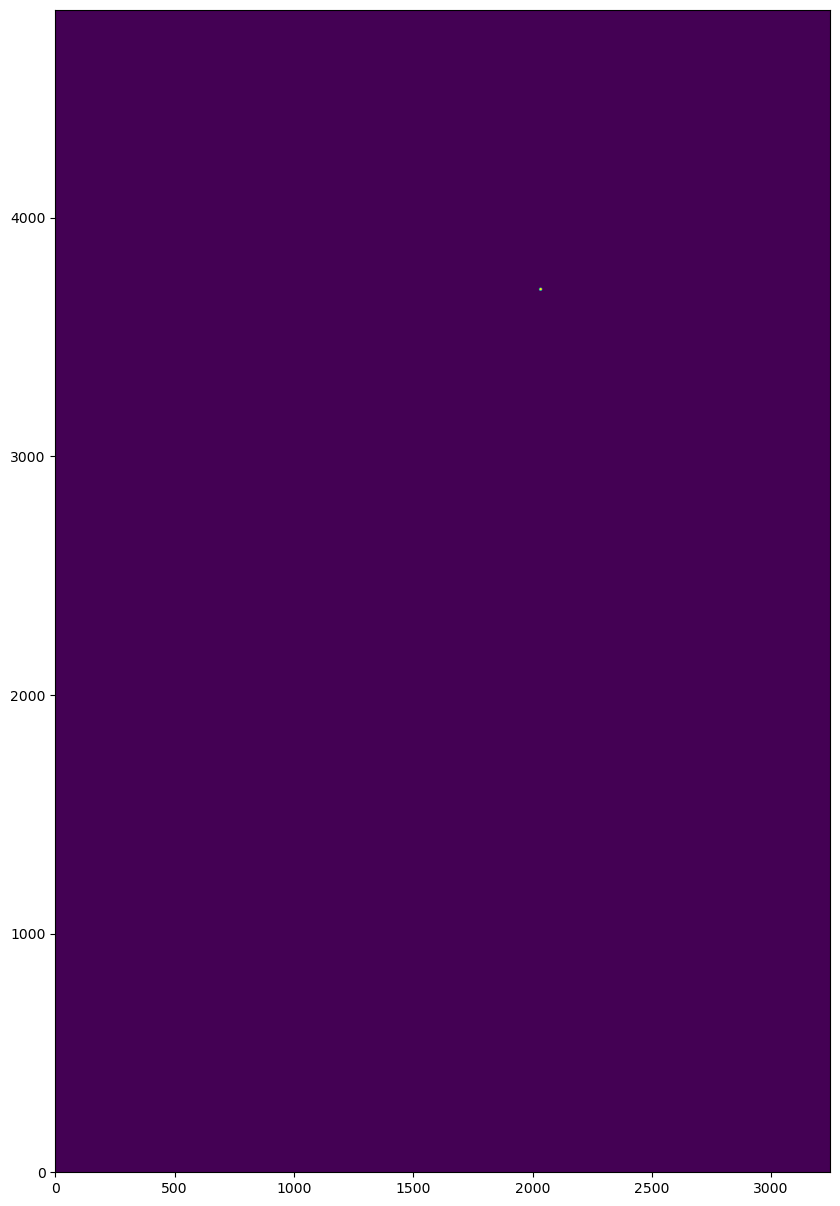

In [66]:
image = masks

fontsize = 10
single_column_width = 10
plt.figure(figsize = (single_column_width/30, single_column_width / 1.61803398875))
fig, ax = plt.subplots(1, 1, figsize=(single_column_width, single_column_width * 1.61803398875), 
                         gridspec_kw={'hspace': 0.0, 'wspace': 0.2})

ax.imshow(image[0], origin ='lower')



In [67]:
%%time
val_loss = train_dataset.full_inference(randint, model)

CPU times: user 44 s, sys: 5.59 s, total: 49.6 s
Wall time: 49.5 s


In [68]:
print(val_loss[0])

tensor(0.9920)


<Figure size 33.3333x618.034 with 0 Axes>

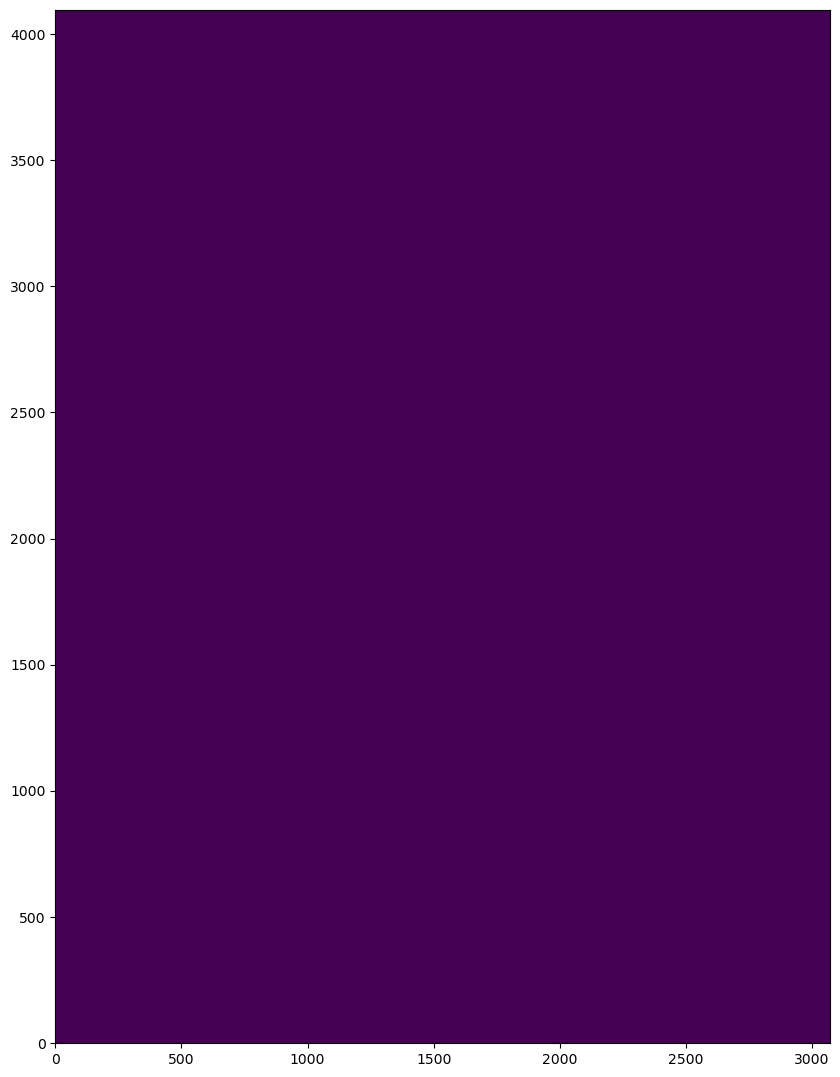

In [69]:
image = val_loss[1]

fontsize = 10
single_column_width = 10
plt.figure(figsize = (single_column_width/30, single_column_width / 1.61803398875))
fig, ax = plt.subplots(1, 1, figsize=(single_column_width, single_column_width * 1.61803398875), 
                         gridspec_kw={'hspace': 0.0, 'wspace': 0.2})

ax.imshow(image[0] > 0.2, origin ='lower')

<Figure size 33.3333x618.034 with 0 Axes>

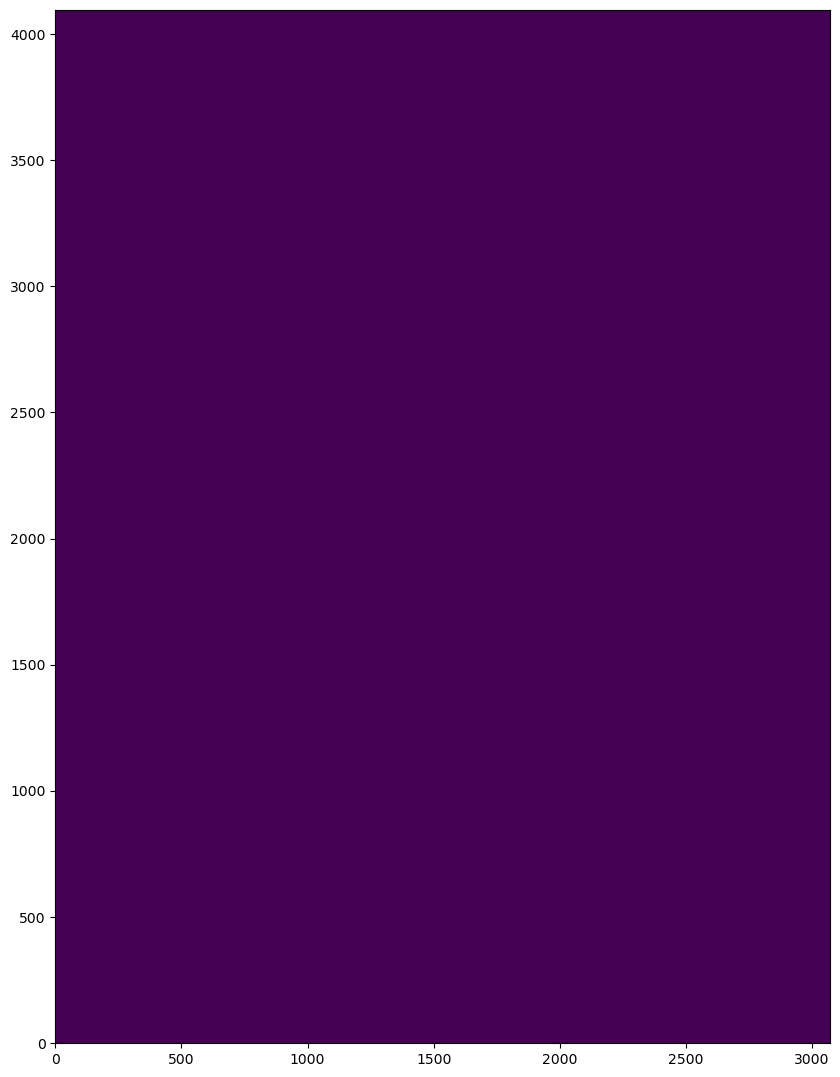

In [71]:
image = val_loss[2]

fontsize = 10
single_column_width = 10
plt.figure(figsize = (single_column_width/30, single_column_width / 1.61803398875))
fig, ax = plt.subplots(1, 1, figsize=(single_column_width, single_column_width * 1.61803398875), 
                         gridspec_kw={'hspace': 0.0, 'wspace': 0.2})

ax.imshow(image, origin ='lower')

In [75]:
mask_tiles = train_dataset.sequential_tile(masks)
print(mask_tiles[(0,0)].shape)

torch.Size([1, 1024, 1024])


In [79]:
mask_reconstruct_raw, mask_reconstruct_counter = train_dataset.tile_reconstruct(mask_tiles)
print(mask_reconstruct_counter.shape)

torch.Size([4096, 3072])


<Figure size 33.3333x618.034 with 0 Axes>

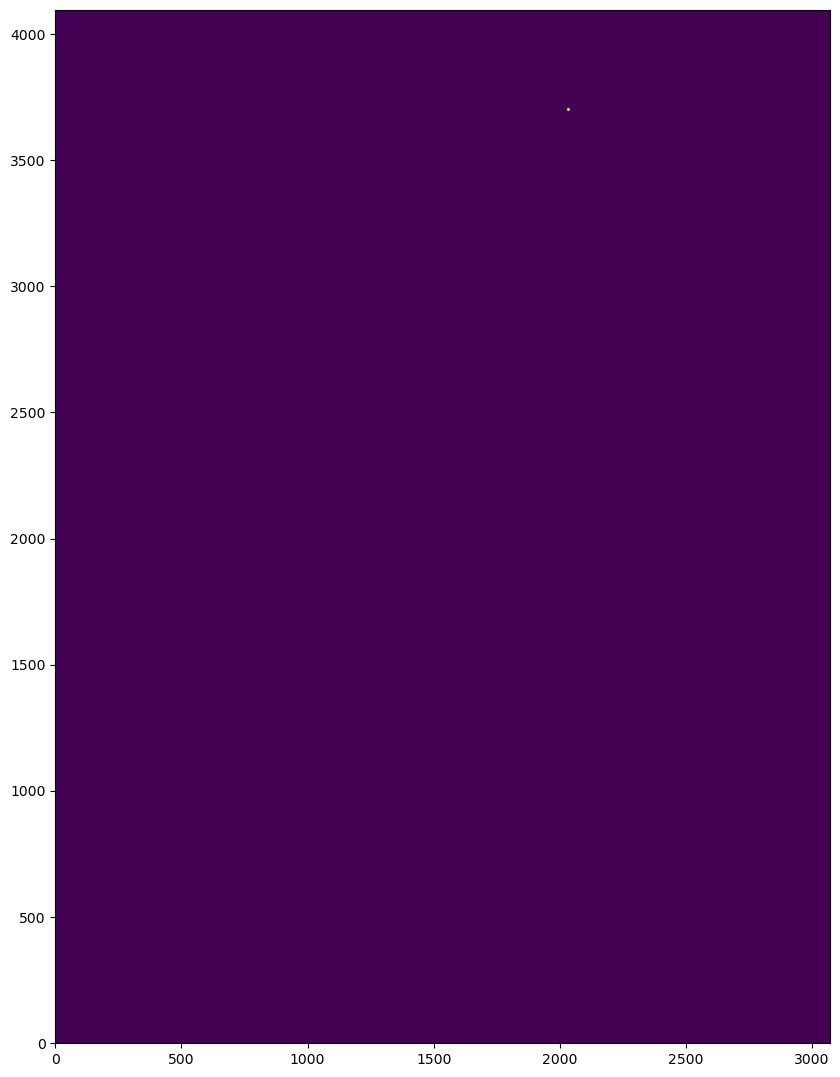

In [82]:
image = mask_reconstruct_raw.squeeze(0).squeeze()

fontsize = 10
single_column_width = 10
plt.figure(figsize = (single_column_width/30, single_column_width / 1.61803398875))
fig, ax = plt.subplots(1, 1, figsize=(single_column_width, single_column_width * 1.61803398875), 
                         gridspec_kw={'hspace': 0.0, 'wspace': 0.2})

ax.imshow(image, origin ='lower')